In [40]:
%%capture
'''
(C) Copyright 2020-2025 Murilo Marques Marinho (murilomarinho@ieee.org)

     This file is licensed in the terms of the
     Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)
     license.

 Derivative work of:
 https://github.com/dqrobotics/learning-dqrobotics-in-matlab/tree/master/robotic_manipulators
 Contributors to this file:
     Murilo Marques Marinho (murilomarinho@ieee.org)
'''

# DQ7 Robot Control Basics using DQ Robotics - Part 3

## Introduction

In the last lesson, you learned how model robotic manipulators parameterized using the DH parameters. You also learned how to use a basic controller based on the pseudo-inverse of the task Jacobian.


That was an introductory exposition to robot control, and this lesson will introduce you to the concept of task-space singularities and a particular way to address them.


In [41]:
%%capture
%pip install dqrobotics
%pip install dqrobotics --break-system-packages

In [42]:
from math import pi
import numpy as np
from dqrobotics import *
from dqrobotics.robot_control import DQ_PseudoinverseController, ControlObjective

## Notation

Keep these in mind (we will also use this notation when writting papers to conferences and journals):

-  $h\in \mathbb{H}$ : a quaternion. (Bold-face, lowercase character)
-  $\underline{h} \in \mathcal{H}$ : a dual quaternion. (Bold-face, underlined, lowercase character)
-  $p,t,\cdots \in {\mathbb{H}}_p$ : pure quaternions. They represent points, positions, and translations. They are quaternions for which $\textrm{Re}\left(h\right)=0$ .
-  $r\in {\mathbb{S}}^3$ : unit quaternions. They represent orientations and rotations. They are quaternions for which $||h||=1$ .
-  $\underline{x} \in$ $\underline{\mathcal{S}}$ : unit dual quaternions. They represent poses and pose transformations. They are dual quaternions for which $||h||=1$ .
-  $\underline{l} \in {\mathcal{H}}_p \cap$ $\underline{{\mathcal{S}}}$ : a Plücker line.
-  $\underline{{{\pi }}} \in \left\lbrace P\left(\underline{{{\pi }}} \right)\in {\mathbb{H}}_p \right\rbrace \cap \underline{{\mathcal{S}}}$ : a plane.
-  $\theta ,a,b,\cdots \in \mathbb{R}$ : real numbers.
-  ${{q,\cdots }}\in {\mathbb{R}}^n :$ real vectors.
-  $J,A,B,\cdots \in {\mathbb{R}}^{m\times n} :$ real matrices.
<a name="H_C7A69651"></a>
## Robot definition

The concepts of this lesson apply to any manipulator robot. However, to have a more concrete understanding using DQ Robotics, consider the following robot that will be used in all examples in this lesson.

<p style="text-align:left">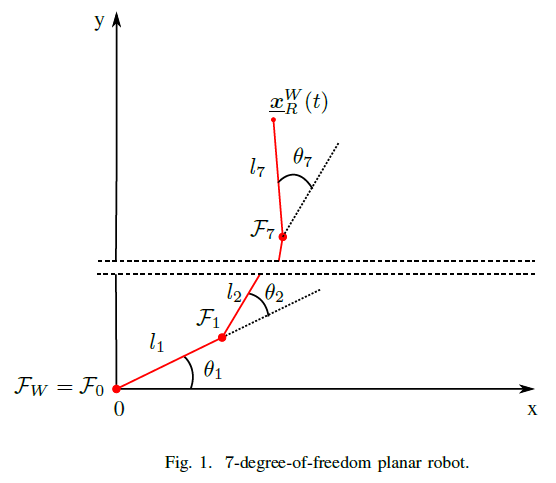</p>


1.  Let the robot $R$ be a 7-DoF planar robot, as drawn in Fig.1.
2. Let ${\mathcal{F}}_W$ be the world-reference frame.
3. Let ${\underline{x} }_R^W (t)\triangleq {\underline{x} }_R$ $\in$ $\underline{\mathcal{S}}$ represent the pose of the *end effector*.
4. Let $R$ be composed of seven rotational joints that rotate about their z-axis, composed in the joint-space vector $q\left(t\right)\triangleq q={\left\lbrack \theta_1 ~\theta_2 ~\theta_3 ~\theta_4 ~\theta_5 ~\theta_6 ~\theta_7 \right\rbrack }^T$ with $\theta_i \left(t\right)\triangleq \theta_i \in \mathbb{R}$ for $i=1,2,\ldots,7$ . The rotation of the reference frames of each joint coincide with the rotation of ${\mathcal{F}}_W$ when $\theta_i =0$ . The length of the joints are $l_i \in$ ${\mathbb{R}}^+ -\lbrace 0\rbrace$ .
5. Consider that we can freely control the joint vector $q$ .

This robot can be modeled by the following class.

In [43]:
from seven_dof_planar_robot_dh import SevenDofPlanarRobotDH
help(SevenDofPlanarRobotDH.kinematics)

Help on function kinematics in module seven_dof_planar_robot_dh:

kinematics()
    Returns the kinematics of the SevenDoFPlanarRobot as DQ_SerialManipulatorDH.



Let us instantiate our robot as follows

In [44]:
seven_dof_planar_robot = SevenDofPlanarRobotDH.kinematics()

<a name="H_5AB990BD"></a>
## Robot controller

The concepts of this lesson also apply for any of the task-space control types mentioned in the last lesson (and others). For us to have a concrete example for this lesson, let us define a translation controller based on the pseudo-inverse of the Jacobian with no damping.


In [45]:
translation_controller = DQ_PseudoinverseController(seven_dof_planar_robot)
translation_controller.set_control_objective(ControlObjective.Translation)
translation_controller.set_gain(10)
translation_controller.set_damping(0)

<a name="H_08B34616"></a>
## Task-space singularities

One important concept when controlling a robot using its task Jacobian is the concept of task-space singularities. The task-space singularities are closely related to the linear-algebra concept of singular matrices. Let us remember a few linear-algebra concepts.

<a name="H_7241FE9B"></a>
### Matrix rank and singularities

Take as an example the $3\times 3$ identity matrix


$$I_{3\times 3} =\left\lbrack \begin{array}{ccc} 1 & 0 & 0\\ 0 & 1 & 0\\ 0 & 0 & 1 \end{array}\right\rbrack .$$

In [46]:
I3_3 = np.eye(3)


It obviously has rank three, that is, its three rows are linearly independent.


In [47]:
np.linalg.matrix_rank(I3_3)

np.int64(3)


However, the following the matrix


$$A=\left\lbrack \begin{array}{ccc} 0 & 0 & 1\\ 0 & 0 & 1\\ 0 & 1 & 0 \end{array}\right\rbrack ,$$

In [48]:
A = np.array([[0, 0, 1],
              [0, 0, 1],
              [0, 1, 0]])


has rank two given that its first and second row are linearly dependent.


In [49]:
np.linalg.matrix_rank(A)

np.int64(2)


A square matrix is considered singular whenever its rank is lower than its number of rows (or columns). This means that the matrix does not have an inverse.


Moreover, non-square matrices also do not have an inverse.


Is there a way to "invert" rectangular matrices and singular matrices?

<a name="H_9FDB8EB8"></a>
### A quick review on the SVD-based inverse for full-rank matrices

Suppose that we want to find a pseudo-inverse for any full-rank matrix $A\in {\mathbb{R}}^{m\times n} ,\textrm{rank}(A)=m$ (which includes non-square ones). For convenience, let us restrict the examples in this lesson for matrices in which $m\le n$ (which also conveniently fit most of the robots we will study in these lessons).


For instance, let us work with


$$A=\left\lbrack \begin{array}{cccc} 2 & 0 & 1 & 2\\ 0 & 0 & 1 & 4\\ 0 & 1 & 0 & 5 \end{array}\right\rbrack .$$

In [50]:
A = np.array([[2, 0, 1, 2],
              [0, 0, 1, 4],
              [0, 1, 0, 5]])


Which has rank three.


In [51]:
np.linalg.matrix_rank(A)

np.int64(3)


As you might remember from your undergraduate-level courses, every real matrix can be decomposed in its singular-value decomposition (SVD) as follows


$$A=U{{\Sigma }}V^T$$

where $U\in {\mathbb{R}}^{m\times m}$ and $V\in {\mathbb{R}}^{n\times n}$ are orthonormal matrices (i.e., they are square, full rank, and their inverses are given by $UU^T =U^T U=I_{m\times m}$ and $VV^T =V^T V=I_{n\times n}$ ). Moreover, ${{\Sigma }}$ is a (rectangular) diagonal matrix composed of the singular values of the matrix given by $\sigma_i$ for $i=1,\ldots,m$ , ordered from the largest singular value towards the smallest singular value. Note that singular values are always non-negative.


<u>**Note: All singular values of a given matrix will be non-zero when the matrix has full rank.**</u>


Calculating this decomposition by hand can be quite complicated and time-consuming for large matrices, so we in practice resort to numerical methods.


In MATLAB you can use the function


In [52]:
help(np.linalg.svd)

Help on _ArrayFunctionDispatcher in module numpy.linalg:

svd(a, full_matrices=True, compute_uv=True, hermitian=False)
    Singular Value Decomposition.
    
    When `a` is a 2D array, and ``full_matrices=False``, then it is
    factorized as ``u @ np.diag(s) @ vh = (u * s) @ vh``, where
    `u` and the Hermitian transpose of `vh` are 2D arrays with
    orthonormal columns and `s` is a 1D array of `a`'s singular
    values. When `a` is higher-dimensional, SVD is applied in
    stacked mode as explained below.
    
    Parameters
    ----------
    a : (..., M, N) array_like
        A real or complex array with ``a.ndim >= 2``.
    full_matrices : bool, optional
        If True (default), `u` and `vh` have the shapes ``(..., M, M)`` and
        ``(..., N, N)``, respectively.  Otherwise, the shapes are
        ``(..., M, K)`` and ``(..., K, N)``, respectively, where
        ``K = min(M, N)``.
    compute_uv : bool, optional
        Whether or not to compute `u` and `vh` in addition to `


With it, we can get the SVD decomposition of our matrix as


In [53]:
U, s, Vh = np.linalg.svd(A)
V = Vh.T # numpy returns the hermitian V


You can verify that the orthonormal matrices follow their properties.


In [54]:
U @ U.T

array([[ 1.00000000e+00, -1.38777878e-16, -1.94289029e-16],
       [-1.38777878e-16,  1.00000000e+00, -3.33066907e-16],
       [-1.94289029e-16, -3.33066907e-16,  1.00000000e+00]])

In [55]:
V.T @ V

array([[ 1.00000000e+00, -5.55111512e-17, -6.93889390e-17,
         0.00000000e+00],
       [-5.55111512e-17,  1.00000000e+00, -6.93889390e-17,
        -1.24900090e-16],
       [-6.93889390e-17, -6.93889390e-17,  1.00000000e+00,
        -1.11022302e-16],
       [ 0.00000000e+00, -1.24900090e-16, -1.11022302e-16,
         1.00000000e+00]])


Given that ${{\Sigma }}$ always has the same dimensions of the original matrix, when the matrix is square, its corresponding ${{\Sigma }}$ will be square


$${{\Sigma }}=\left\lbrack \begin{array}{cccc} \sigma_1  & 0 & \cdots  & 0\\ 0 & \sigma_2  & \ldots & 0\\ 0 & \vdots  & \ddots  & 0\\ 0 & 0 & 0 & \sigma_m  \end{array}\right\rbrack$$

When the matrix is rectangular, its corresponding ${{\Sigma }}$ will be rectangular, for instance


$${{\Sigma }}=\left\lbrack \begin{array}{ccccc} \sigma_1  & 0 & \cdots  & 0 & 0\\ 0 & \sigma_2  & \ldots & 0 & 0\\ 0 & \vdots  & \ddots  & 0 & 0\\ 0 & 0 & 0 & \sigma_m  & 0 \end{array}\right\rbrack$$

In [56]:
s

array([6.83935954, 2.09392491, 0.91577269])

or matrix

In [57]:
S = np.array([[s[0],   0,     0,    0],
              [0,      s[1],  0,    0],
              [0,      0,     s[2], 0]])


With these properties, a right pseudo-inverse can be defined for any matrix for which all singular values are non-zero. The right pseudo-inverse is


$$A^{\dagger} \triangleq V{{{\Sigma }}}^{\textrm{inv}} U^T,$$


where ${{{\Sigma }}}^{\textrm{inv}}$ is a compatible matrix where we use the reciprocal of the singular values. For example, for a square matrix we have


$${{{\Sigma }}}^{inv} \triangleq \left\lbrack \begin{array}{cccc} \frac{1}{\sigma_1 } & 0 & \cdots  & 0\\ 0 & \frac{1}{\sigma_2 } & \ldots & 0\\ 0 & \vdots  & \ddots  & 0\\ 0 & 0 & 0 & \frac{1}{\sigma_m } \end{array}\right\rbrack$$

and for a rectangular matrix


$${{{\Sigma }}}^{inv} \triangleq \left\lbrack \begin{array}{cccc} \frac{1}{\sigma_1 } & 0 & \cdots  & 0\\ 0 & \frac{1}{\sigma_2 } & \ldots & 0\\ 0 & \vdots  & \ddots  & 0\\ 0 & 0 & 0 & \frac{1}{\sigma_m }\\ 0 & 0 & 0 & 0 \end{array}\right\rbrack.$$

In [58]:
S_inv = np.array([[1.0/s[0],   0,          0],
                  [0,          1.0/s[1],   0],
                  [0,          0,          1.0/s[2]],
                  [0,          0,          0]])


Then, we find that


$${{\Sigma }}{{{\Sigma }}}^{inv} =I_{m\times m} .$$

In [59]:
S @ S_inv

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])


Therefore, we find that


$$AA^{\dagger} =U{{\Sigma }}V^T V{{{\Sigma }}}^{\textrm{inv}} U^T$$

$$AA^{\dagger} =I_{m\times m} \:\textrm{(see}\;\textrm{Bonus}\;\textrm{Homework}\;\textrm{1)}$$

In [60]:
A_dagger = V @ S_inv @ U.T
A @ A_dagger

array([[ 1.00000000e+00,  1.94289029e-16, -6.66133815e-16],
       [-2.28983499e-16,  1.00000000e+00,  6.10622664e-16],
       [-2.37657116e-16, -6.24500451e-16,  1.00000000e+00]])


This inverse has several interesting properties that we will discuss when they are needed.

<a name="H_EFF1B965"></a>
### A quick review on the SVD-based inverse for singular matrices

In practice, we want our algorithm to be able to invert even singular matrices. Let $B\in {\mathbb{R}}^{m\times n}$ be such that $\textrm{rank}(B)=r<m$ . For convenience, let us restrict the examples for matrices in which $m\le n$ . For instance, let us use


 $B=\left\lbrack \begin{array}{cccc} 2 & 0 & 1 & 2\\ 0 & 0 & 1 & 4\\ 2 & 0 & 1 & 2 \end{array}\right\rbrack$ ,


In [61]:
B = np.array([[2, 0, 1, 2,
               0, 0, 1, 4,
               2, 0, 1, 2]])


that has rank two.


In [62]:
np.linalg.matrix_rank(B)

np.int64(1)


Similarly to full-rank matrices, the SVD-based inverse can also be used for singular matrices. In our case,  $m-r$ singular values will be zero.


<u>**Note: A matrix is singular when at least one of its singular values is zero.**</u>


The null singular values are ignored when we calculate the "inverse" of the matrix that holds the singular values, as follows


$${{{\Sigma }}}^{inv} =\left\lbrack \begin{array}{cccccc} \frac{1}{\sigma_1 } & 0 & \cdots  & 0 & \cdots  & 0\\ 0 & \frac{1}{\sigma_2 } & \ldots & 0 & \cdots  & 0\\ 0 & \vdots  & \ddots  & 0 & \cdots  & 0\\ 0 & 0 & 0 & \frac{1}{\sigma_r } & \cdots  & 0\\ \vdots  & \vdots  & \vdots  & \vdots  & \ddots  & 0\\ 0 & 0 & 0 & 0 & \cdots  & 0 \end{array}\right\rbrack .$$

This means that when the pseudo-inverse is applied, the result will be "as close as possible" to the identity. The meaning of "as close as possible" will be somewhat fuzzy for now, but it will get clearer as the lessons progress. Just understand that if $\textrm{rank}(B)<m$ , there is no matrix $B^{inv}$ such that $BB^{inv} =I_{m\times m}$ . We <u>***have***</u> to compromise.


MATLAB has an implementation for the SVD-based inverse (and you already used it in lesson 5).


In [63]:
help(np.linalg.pinv)

Help on _ArrayFunctionDispatcher in module numpy.linalg:

pinv(a, rcond=None, hermitian=False, *, rtol=<no value>)
    Compute the (Moore-Penrose) pseudo-inverse of a matrix.
    
    Calculate the generalized inverse of a matrix using its
    singular-value decomposition (SVD) and including all
    *large* singular values.
    
    .. versionchanged:: 1.14
       Can now operate on stacks of matrices
    
    Parameters
    ----------
    a : (..., M, N) array_like
        Matrix or stack of matrices to be pseudo-inverted.
    rcond : (...) array_like of float, optional
        Cutoff for small singular values.
        Singular values less than or equal to
        ``rcond * largest_singular_value`` are set to zero.
        Broadcasts against the stack of matrices. Default: ``1e-15``.
    hermitian : bool, optional
        If True, `a` is assumed to be Hermitian (symmetric if real-valued),
        enabling a more efficient method for finding singular values.
        Defaults to False.



In our case, we can calculate for $B$ . Using this pseudo-inverse will not result in the identity because $\textrm{rank}(B)\le m$ , as follows


In [64]:
B @ np.linalg.pinv(B)

array([[1.]])


Note that the same function it can also be used for $A$ . Using this pseudo-inverse will result in the identity because $\textrm{rank}(A)=m$ , as follows


In [65]:
A @ np.linalg.pinv(A)

array([[ 1.00000000e+00,  1.94289029e-16, -6.38378239e-16],
       [-2.28983499e-16,  1.00000000e+00,  6.10622664e-16],
       [-2.58473798e-16, -6.24500451e-16,  1.00000000e+00]])

<a name="H_76F44C17"></a>
### So, after all this, what are task-space singularities, then?

Task-space singularities are postures, that is, combinations of joint values for which the rank of the task Jacobian is smaller than the dimension of the task-space.


<u>**Note: A task-space singulary depends on the definition of task-space.**</u>


To make that understanding somewhat more concrete, let us go back to our example, where we are controlling the translation of the end effector of our 7 degrees-of-freedom planar-robot.


If we define our task space as the 3D translation, that is the translation in the $x-$ axis, $y-$ axis, and $z-$ axis, then all robot postures will be singular because the $z-$ axis translation of our planar robot cannot be controlled. The maximum rank of the translation Jacobian of our planar robot will always be less or equal to two.


In [66]:
q = np.random.rand(7)
x = seven_dof_planar_robot.fkm(q)
Jx = seven_dof_planar_robot.pose_jacobian(q)
Jt = seven_dof_planar_robot.translation_jacobian(Jx, x)
np.linalg.matrix_rank(Jt)

np.int64(2)


If we define our task-space as the 2D translation of the $x-$ axis and the $y-$ axis, then most of the robot postures will not be singular. However, some of them will still be.


For instance, when all links are aligned at $\theta_i =0$ $\forall$ $i$ ,


In [67]:
q = np.zeros(7)
x = seven_dof_planar_robot.fkm(q)
Jx = seven_dof_planar_robot.pose_jacobian(q)
Jt = seven_dof_planar_robot.translation_jacobian(Jx,x)
np.linalg.matrix_rank(Jt)

np.int64(1)

<a name="H_8D4B3DED"></a>
### I see, but what is the problem?

The problem are not the task-space singularities themselves, but in the transition between singular and non-singular postures. Remember that the SVD-based inverse is based on


$${{{\Sigma }}}^{inv} =\left\lbrack \begin{array}{cccccc} \frac{1}{\sigma_1 } & 0 & \cdots  & 0 & \cdots  & 0\\ 0 & \frac{1}{\sigma_2 } & \ldots & 0 & \cdots  & 0\\ 0 & \vdots  & \ddots  & 0 & \cdots  & 0\\ 0 & 0 & 0 & \frac{1}{\sigma_r } & \cdots  & 0\\ \vdots  & \vdots  & \vdots  & \vdots  & \ddots  & 0\\ 0 & 0 & 0 & 0 & \cdots  & 0 \end{array}\right\rbrack .$$

which means that we take the reciprocal of the singular values. The reciprocal of the singular values can be very large numbers when the singular values are small.


This causes the SVD-based pseudo-inverse to output unfeasible velocities to the manipulator, that can be dangerous for the robot itself (it can break), and it can damage people/things in its vicinity.


First, consider a non-singular posture for our example manipulator, such as $\theta_i =\pi /2$ $\forall$ $i$ . Calculate the next iteration of our controller for the reference $t_d =7\hat{\jmath}$ .


In [68]:
td = 7 * j_
q = (pi/2.0) * np.ones(7) 
u = translation_controller.compute_setpoint_control_signal(q, vec4(td))
max(u)

np.float64(14.999999999999986)


which is a resonable maximum joint velocity (remember that the unit in question is radians per second).


Now, let us try that in the vicinity of a singularity. For instance, back to our example, consider an initial posture $\theta_i =0.00001$ $\forall$ $i$


In [69]:
td = 7 * j_
q = 0.00001 * np.ones(7)
translation_controller.compute_setpoint_control_signal(q, vec4(td))
u = translation_controller.compute_setpoint_control_signal(q, vec4(td))
max(u)

np.float64(382336.47056177165)


which is a completely unreasonable maximum joint velocity. In fact, the closer you are to the singularity, the worse the behavior will be.


For instance, consider an initial posture $\theta_i =0.000000001$ $\forall$ $i$


In [70]:
td = 7 * j_
q = 0.000000001 * np.ones(7)
translation_controller.compute_setpoint_control_signal(q, vec4(td))
u = translation_controller.compute_setpoint_control_signal(q, vec4(td))
max(u)

np.float64(3823529395.294118)


which is a even more unreasonable maximum joint velocity.

<a name="H_725A6619"></a>
### Ok, I still don't understand. What is the problem?

Let us control our example robot from $\theta_i =0$ $\forall$ $i$ to $t_d =7\hat{\jmath}$ using the SVD-based pseudo-inverse.


This simulation will be run in slow motion and so that you can see the weird behavior of the robot near the singularity.


Instead of moving in a smooth manner, the robot teleports to a far-away posture and contorts itself because of the unreasonably high-velocities caused by the SVD-based pseudo-inverse.


In DQ Robotics, the SVD-based pseudo-inverse will be used if the damping factor is zero for a "DQ_PseudoinverseController".


In [71]:
# Define the robot
seven_dof_planar_robot = SevenDofPlanarRobotDH.kinematics()

# Define the controller
translation_controller = DQ_PseudoinverseController(seven_dof_planar_robot)
translation_controller.set_control_objective(ControlObjective.Translation)
translation_controller.set_gain(10)
translation_controller.set_damping(0)

# Desired translation (pure quaternion)
td = 7 * j_
# Sampling time [s]
tau = 0.01
# Simulation time [s]
time_final = 1
# Initial joint values [rad]
q = np.zeros(7)
# Store the control signals
stored_u = []

# Translation controller loop.
for time in np.arange(0, time_final + tau,tau):
    # Get the next control signal [rad/s]
    u = translation_controller.compute_setpoint_control_signal(q, vec4(td))

    # Move the robot
    q = q + u * tau

    # Store data
    # stored_u = [stored_u u];

    # Plot
    # Plot the robot
    # plot(seven_dof_planar_robot,q);
    # title(['Translation control' ' time=' num2str(time) 's out of ' num2str(final_time) 's'])
    # Plot the desired pose
    # hold on
    # plot3(td.q(2),td.q(3),td.q(4));
    # hold off
    # [For animations only]
    # drawnow; % [For animations only] Ask MATLAB to draw the plot now
    # pause(0.5)


The issue can be clearly seen when we plot the first 0.1 sec of the controller output. In the first control step, there is no issue because the robot is in a singular posture. When the robot moves a bit away from the singular posture, the next control signal "explodes".


In [72]:
# plot_u(stored_u,0:tau:final_time,10)


There are three main points that need to be understood about task-space singularities.

1.  <u>**singularities have to be addressed so that the robot does not damage itself and things/people in its surroundings,**</u>
2. <u>**singularities are a manifestation of mechanical phenomena related to the definition of the task-space. They do not mean the mathematic model is broken, they simply and correctly represent a mechanical issue.**</u>
3. <u>**singularities usually occur when joints are aligned, but predicting singular configurations for robots with a large number of degrees-of-freedom is not trivial.**</u>
<a name="H_B1A4D228"></a>
## Damped pseudo-inverse

The damped pseudo-inverse is an interesting alternative to the SVD-based inverse that gives the system some robustness to task-space singularities. The main idea is to use the following pseudo-inverse for any (possibly singular) matrix $B\in {\mathbb{R}}^{m\times n}$ , called the *damped-pseudo inverse*


$$B^+ \triangleq {\left(B^T B+\lambda^2 I\right)}^{-1} B^T$$

where $\lambda \in \mathbb{R}-\lbrace 0\rbrace$ is the damping factor. The meaning of this damping factor will become clearer in the next lesson, but for now it suffices to know that given that


$${\left(B^T B+\lambda^2 I\right)}^{-1} \:\textrm{(Bonus}\;\textrm{Homework}\;\textrm{2)}$$

always exists, regular inversion algorithms can be used to calculate the damped pseudo-inverse. Using MATLAB, this would mean, for instance


In [73]:
B = np.array([[2, 0, 1, 2],
              [0, 0, 1, 4],
              [2, 0, 1, 2]])

In [74]:
λ = 0.01
B_damped_pinv = np.linalg.inv(B.T @ B + (λ ** 2) * np.eye(4)) @ B.T

In [75]:
B @ B_damped_pinv

array([[4.99994097e-01, 6.24984841e-06, 4.99994097e-01],
       [6.24984750e-06, 9.99987500e-01, 6.24984750e-06],
       [4.99994097e-01, 6.24984841e-06, 4.99994097e-01]])

<a name="H_90195E7B"></a>
### Damped pseudo-inverse and singularity robustness

In the point-of-view of Jacobian-based robot control, the damping factor lets us balance the trade-off between optimal joint velocities (in the sense of task error reduction) and joint velocity norm.


If you choose a larger damping factor, the robot will be more robust to task-space singularities, but it might take longer to reach the desired task-space value. As you lower the damping factor, the behavior gets closer to the SVD-based pseudo-inverse. If the damping is too low, the joint velocities will also be dangerous when the robot is close to singular configurations.


To show a concrete example of the damped pseudo-inverse in action, let us copy and paste our prior example. After that, we change only the damping factor and see its effect on robot control.


In [76]:
# Define the robot
seven_dof_planar_robot = SevenDofPlanarRobotDH.kinematics()

# Define the controller
translation_controller = DQ_PseudoinverseController(seven_dof_planar_robot)
translation_controller.set_control_objective(ControlObjective.Translation)
translation_controller.set_gain(10)

damping = 1

In [77]:
translation_controller.set_damping(damping)

# Desired translation (pure quaternion)
td = 7 * j_
# Sampling time [s]
tau = 0.01
# Simulation time [s]
time_final = 1
# Initial joint values [rad]
q = np.zeros(7)
# Store the control signals
stored_u = []

# Translation controller loop.
for time in np.arange(0, time_final + tau,tau):
    # Get the next control signal [rad/s]
    u = translation_controller.compute_setpoint_control_signal(q, vec4(td))

    # Move the robot
    q = q + u * tau

    # Store data
    # stored_u = [stored_u u];

    # Plot
    # Plot the robot
    # plot(seven_dof_planar_robot,q);
    # title(['Translation control' ' time=' num2str(time) 's out of ' num2str(final_time) 's'])
    # Plot the desired pose
    # hold on
    # plot3(td.q(2),td.q(3),td.q(4));
    # hold off
    # [For animations only]
    # drawnow; % [For animations only] Ask MATLAB to draw the plot now
    # pause(0.5)

In [78]:

# plot_u(stored_u,0:tau:final_time,10)


As you can also see from the plotted values, the robot safely moved towards the goal without excessive joint velocities when $\lambda =1$ .

<a name="T_799C3A33"></a>
# <span style="color:rgb(213,80,0)">Homework</span>

Consider the 7-DoF planar robot used during this lesson. Consider the following damping values $\lambda \in \left\lbrace 0.001,0.01,0.1,0.2,0.3,0.4,0.5,1\right\rbrace$ .


 **Condition 1:** $\theta_i =0$ $\forall$ $i$ to $t_d =7\hat{\jmath}$ . $\eta =10,\tau =0.01$


Create a file called [seven_dof_robot_damping_comparison_singular.m] that does the following

1.  Run the following nine controllers: one SVD-based pseudoinverse translation controller AND eight damped-pseudo inverse translation controllers, each one with one of the damping values defined above. Store their ***task-space error norm*** and their ***control signal norm***.
2. Using subplot with one row and two columns: plot on the left subplot the  ***task-space error norm***  for all controllers, so that they can be compared. On the right subplot, plot the  ***control signal norm*** for all controllers so that they can be compared*.*

 **Condition 2:** $\theta_i =\pi /12$ $\forall$ $i$ to $t_d =7\hat{\jmath}$ . $\eta =10,\tau =0.01$


Create a file called [seven_dof_robot_damping_comparison.m] that does the following

1.  Run the following nine controllers: one SVD-based pseudoinverse translation controller AND eight damped-pseudo inverse translation controllers, each one with one of the damping values defined above. Store their ***task-space error norm*** and their ***control signal norm***.
2. Using subplot with one row and two columns: plot on the left subplot the  ***task-space error norm***  for all controllers, so that they can be compared. On the right subplot, plot the  ***control signal norm*** for all controllers so that they can be compared*.*
<a name="T_AD44DC70"></a>
# <span style="color:rgb(213,80,0)">*Bonus Homework*</span>

Do the following on pen-and-paper or in your favorite text editor.

1.  Show that $AA^{\dagger} =U{{\Sigma }}V^T V{{{\Sigma }}}^{\textrm{inv}} U^T =I_{m\times m}$ for any matrix $A^{m\times n} ,\textrm{rank}(A)=m$ , $m\le n$ , with other variables as defined in this lesson.
2. Show that $\left(B^T B+\lambda I\right)$ is always invertible, for any matrix $B^{m\times n} ,\textrm{rank}(B)<m$ , $m\le n$ , with other variables as defined in this lesson.
